In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit
from time import perf_counter as time
from functools import lru_cache, cache
import scipy.optimize

## Versuch Schlafzimmer

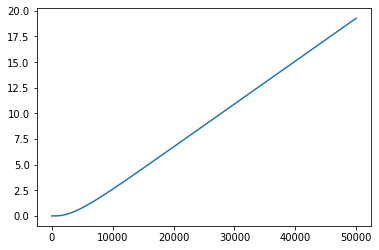

In [2]:
sensor_schlaf = np.loadtxt("schlafzimmer_simulation.txt")
plt.plot(sensor_schlaf)
plt.show()
# delta = sensor_schlaf[-1] - sensor_schlaf[-2]
# sensor_schlaf = np.concatenate((sensor_schlaf, np.arange(sensor_schlaf[-1] + delta, delta, 500)))

def get_y_schlaf(times, d, s, ox=0, oy=0):
    dt = 1
    dd = 0.001
    try:
        res = np.zeros(len(times))
        for i, t in enumerate(times):
            index = ((t-ox)/dt * d/dd)
            if index <= 0:
                res[i] = 0
            elif index < len(sensor_schlaf):
                res[i] = sensor_schlaf[int(index)]
            else:
                res[i] = sensor_schlaf[-1] + (index - len(sensor_schlaf) + 1) * (sensor_schlaf[-1] - sensor_schlaf[-2])
            res[i] = res[i] * s * dd/d + oy
        return res
    except Exception as e:
        index = ((times-ox)/dt * d/dd)
        if index <= 0:
            return oy
        elif index < len(sensor_schlaf):
            return sensor_schlaf[int(index)] * s * dd/d + oy
        else:
            return sensor_schlaf[-1] + (index - len(sensor_schlaf) + 1) * (sensor_schlaf[-1] - sensor_schlaf[-2]) * s * dd/d + oy

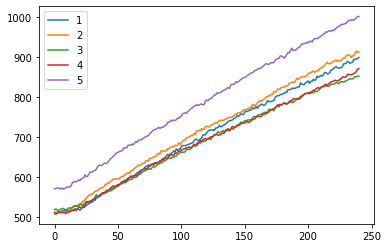

In [3]:
schlaf1_file = np.genfromtxt(r"..\Data\Messungen\20210110_153212_log.csv", skip_header=46, skip_footer=2, delimiter=",")
schlaf1 = schlaf1_file[:, 3]
schlaf2_file = np.genfromtxt(r"..\Data\Messungen\20210110_170115_log.csv", skip_header=46, skip_footer=2, delimiter=",")
schlaf2 = schlaf2_file[:, 3]
schlaf3_file = np.genfromtxt(r"..\Data\Messungen\20210113_145516_log.csv", skip_header=46, skip_footer=2, delimiter=",")
schlaf3 = schlaf3_file[:, 3]
schlaf4_file = np.genfromtxt(r"..\Data\Messungen\20210113_162641_log.csv", skip_header=46, skip_footer=2, delimiter=",")
schlaf4 = schlaf4_file[:, 3]
schlaf5_file = np.genfromtxt(r"..\Data\Messungen\20210114_144535_log.csv", skip_header=46, skip_footer=2, delimiter=",")
schlaf5 = schlaf5_file[:, 3]

x_list = np.arange(0, len(schlaf1)*10, 10)

plt.plot(schlaf1, label="1")
plt.plot(schlaf2, label="2")
plt.plot(schlaf3, label="3")
plt.plot(schlaf4, label="4")
plt.plot(schlaf5, label="5")
plt.legend()
plt.show()

      fun: 1311.300000000032
 hess_inv: array([[ 5.06235825e-04, -2.89871347e-04,  5.91104619e-04,
        -9.68268182e-05],
       [-2.89871347e-04,  2.59768832e-03, -3.17566030e-03,
         8.65632486e-04],
       [ 5.91104619e-04, -3.17566030e-03,  4.00085561e-03,
        -1.05863952e-03],
       [-9.68268182e-05,  8.65632486e-04, -1.05863952e-03,
         2.89040599e-04]])
      jac: array([3.05175781e-05, 0.00000000e+00, 0.00000000e+00, 3.05175781e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 465
      nit: 14
     njev: 90
   status: 2
  success: False
        x: array([ -2.24999923,  -6.09999929,   2.40000052, -61.9499992 ])


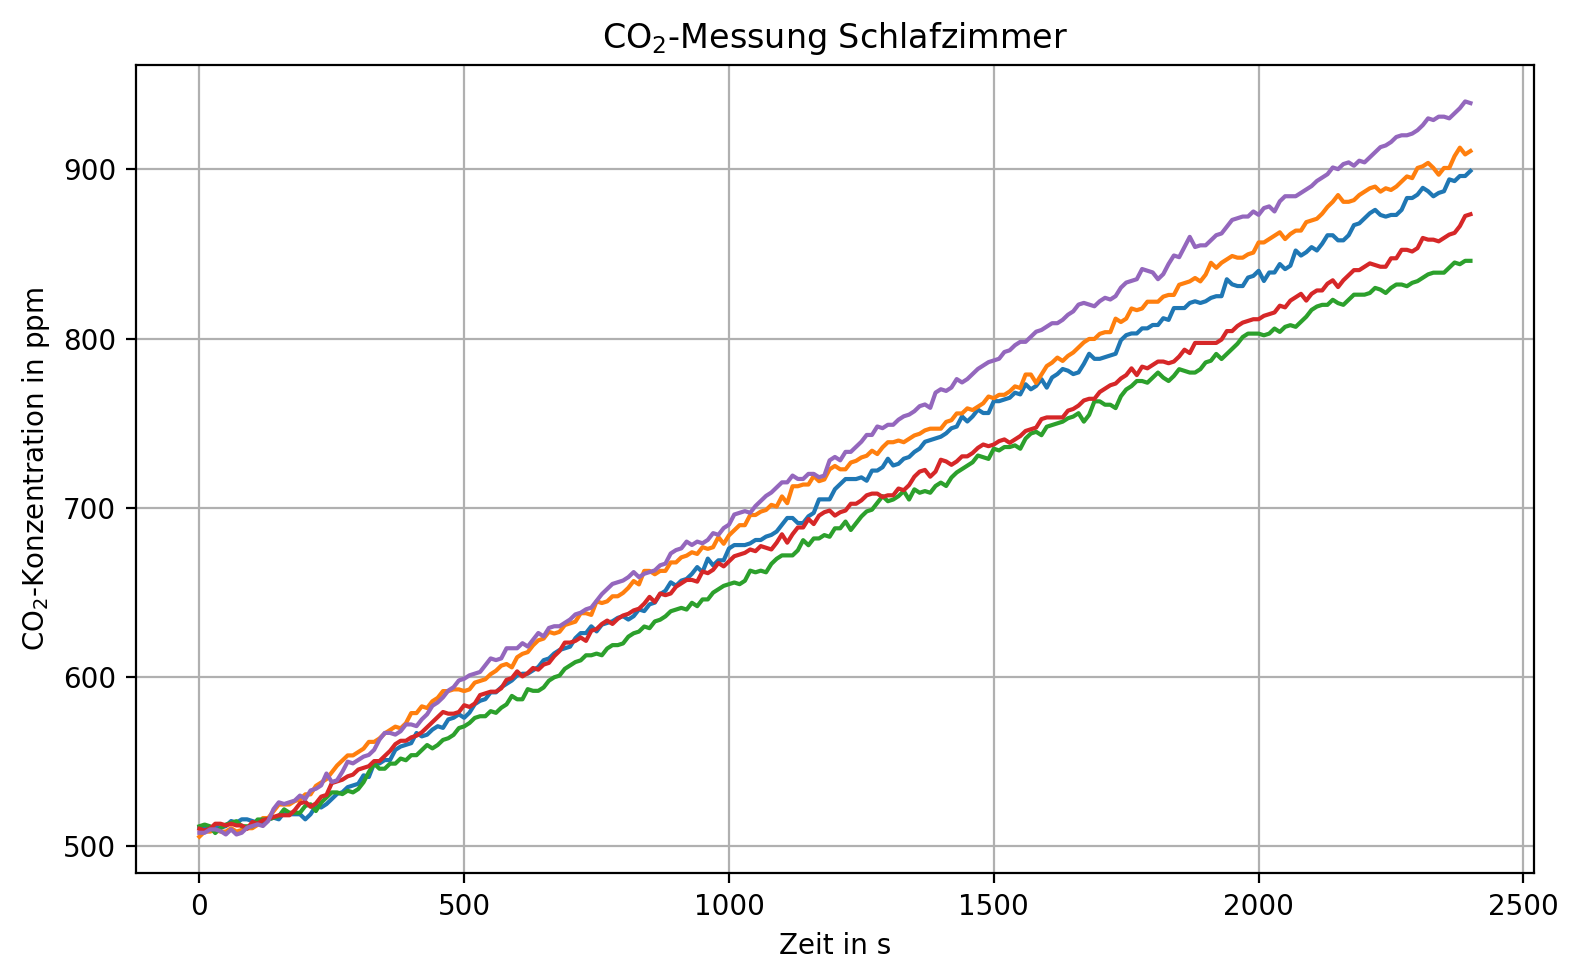

In [4]:
def find_offset(x):
    a, b, c, d = x
    res = 0
    for s1, s2, s3, s4, s5 in zip(schlaf1, schlaf2, schlaf3, schlaf4, schlaf5[:20]):
        d2 = (s1 - (s2+a))**2
        d3 = (s1 - (s3+b))**2
        d4 = (s1 - (s4+c))**2
        d5 = (s1 - (s5+d))**2
        res += d2  + d3 + d4 + d5
    return res

result = scipy.optimize.minimize(find_offset, [0, 0, 0, 60])
offsets = result.x
print(result)

fig = plt.figure(figsize=(8, 5), dpi=200)
ax = fig.add_subplot(111)

ax.set_title("CO$_2$-Messung Schlafzimmer")
ax.grid("both")

ax.set_xlabel(r"Zeit in s")
ax.set_ylabel(r"CO$_2$-Konzentration in ppm")

ax.plot(x_list, schlaf1, label="1")
ax.plot(x_list, schlaf2 + offsets[0], label="2")
ax.plot(x_list, schlaf3 + offsets[1], label="3")
ax.plot(x_list, schlaf4 + offsets[2], label="4")
ax.plot(x_list, schlaf5 + offsets[3], label="5")
# ax.legend()
fig.tight_layout()
plt.savefig("offset_schlafzimmer.png")
plt.show()

In [5]:
o = schlaf1[0]
max_i = 60
versuch = np.concatenate((schlaf1[:max_i]-o, schlaf2[:max_i]+offsets[0]-o, schlaf3[:max_i]+offsets[1]-o, schlaf4[:max_i]+offsets[2]-o, schlaf5[:max_i]+offsets[3]-o))
x_list_full = np.concatenate((x_list[:max_i], x_list[:max_i], x_list[:max_i], x_list[:max_i], x_list[:max_i]))



[ 3.08999017e-02  4.84791266e+02  6.84423052e-07 -1.90961166e+00]


c:\program files\python39\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


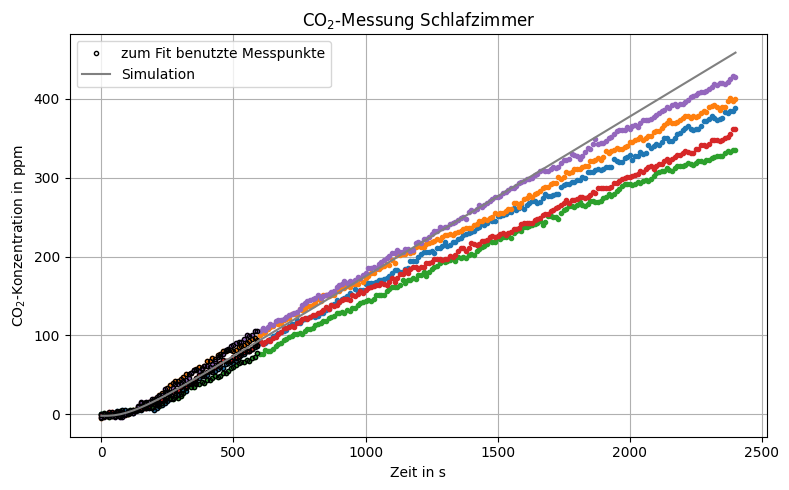

In [6]:
coeff, err = scipy.optimize.curve_fit(get_y_schlaf, x_list_full, versuch, p0=(0.04, 370, -0, -3))

print(coeff)
x_list_plot = np.linspace(0, 2400, 100)

fig = plt.figure(figsize=(8, 5), dpi=100)
ax = fig.add_subplot(111)

ax.set_title(r"CO$_2$-Messung Schlafzimmer")
ax.grid("both")

ax.set_xlabel(r"Zeit in s")
ax.set_ylabel(r"CO$_2$-Konzentration in ppm")

ax.plot(x_list, schlaf1-o, ".")
ax.plot(x_list, schlaf2+offsets[0]-o, ".")
ax.plot(x_list, schlaf3+offsets[1]-o, ".")
ax.plot(x_list, schlaf4+offsets[2]-o, ".")
ax.plot(x_list, schlaf5+offsets[3]-o, ".")
ax.plot(x_list_full, versuch, "k.", label="zum Fit benutzte Messpunkte", fillstyle="none")
ax.plot(x_list_plot, get_y_schlaf(x_list_plot, *coeff), "grey", label="Simulation")
ax.legend()

fig.tight_layout()
plt.savefig("fit_schlafzimmer.png")
plt.show()

## Versuch Badezimmer

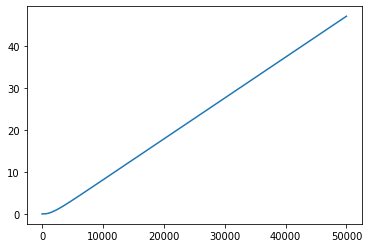

In [18]:
sensor_bad = np.loadtxt("badezimmer_simulation.txt")
plt.plot(sensor_bad)
plt.show()
# delta = sensor_schlaf[-1] - sensor_schlaf[-2]
# sensor_schlaf = np.concatenate((sensor_schlaf, np.arange(sensor_schlaf[-1] + delta, delta, 500)))

def get_y_bad(times, d, s, ox=0, oy=0):
    dt = 1
    dd = 0.001
    try:
        res = np.zeros(len(times))
        for i, t in enumerate(times):
            index = ((t-ox)/dt * d/dd)
            if index <= 0:
                res[i] = 0
            elif index < len(sensor_bad):
                res[i] = sensor_bad[int(index)]
            else:
                res[i] = sensor_bad[-1] + (index - len(sensor_bad) + 1) * (sensor_bad[-1] - sensor_bad[-2])
            res[i] = res[i] * s * dd/d + oy
        return res
    except Exception as e:
        index = ((times-ox)/dt * d/dd)
        if index <= 0:
            return oy
        elif index < len(sensor_bad):
            return sensor_bad[int(index)] * s * dd/d + oy
        else:
            return sensor_bad[-1] + (index - len(sensor_bad) + 1) * (sensor_bad[-1] - sensor_bad[-2]) * s * dd/d + oy

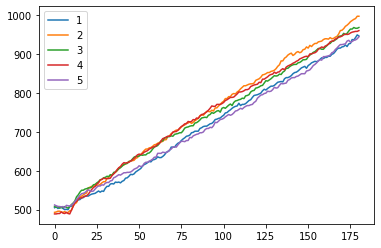

In [19]:
bad1_file = np.genfromtxt(r"..\Data\Messungen\20210107_144717_log.csv", skip_header=46, skip_footer=2, delimiter=",")
bad1 = bad1_file[:, 3]
bad2_file = np.genfromtxt(r"..\Data\Messungen\20210107_160932_log.csv", skip_header=46, skip_footer=2, delimiter=",")
bad2 = bad2_file[:, 3]
bad3_file = np.genfromtxt(r"..\Data\Messungen\20210107_173144_log.csv", skip_header=46, skip_footer=2, delimiter=",")
bad3 = bad3_file[:, 3]
bad4_file = np.genfromtxt(r"..\Data\Messungen\20210108_140032_log.csv", skip_header=46, skip_footer=2, delimiter=",")
bad4 = bad4_file[:, 3]
bad5_file = np.genfromtxt(r"..\Data\Messungen\20210108_150359_log.csv", skip_header=46, skip_footer=2, delimiter=",")
bad5 = bad5_file[:, 3]

x_list = np.arange(0, len(bad1)*10, 10)

plt.plot(bad1, label="1")
plt.plot(bad2, label="2")
plt.plot(bad3, label="3")
plt.plot(bad4, label="4")
plt.plot(bad5, label="5")
plt.legend()
plt.show()

      fun: 3440.3000000000106
 hess_inv: array([[ 0.01547791, -0.00835369, -0.00665849,  0.00290746],
       [-0.00835369,  0.01957929, -0.00221569, -0.00788396],
       [-0.00665849, -0.00221569,  0.01543012, -0.00126035],
       [ 0.00290746, -0.00788396, -0.00126035,  0.0303515 ]])
      jac: array([6.10351562e-05, 6.10351562e-05, 6.10351562e-05, 0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 272
      nit: 11
     njev: 52
   status: 2
  success: False
        x: array([ 3.90000039, -7.89999953,  6.95000117, -6.24999993])


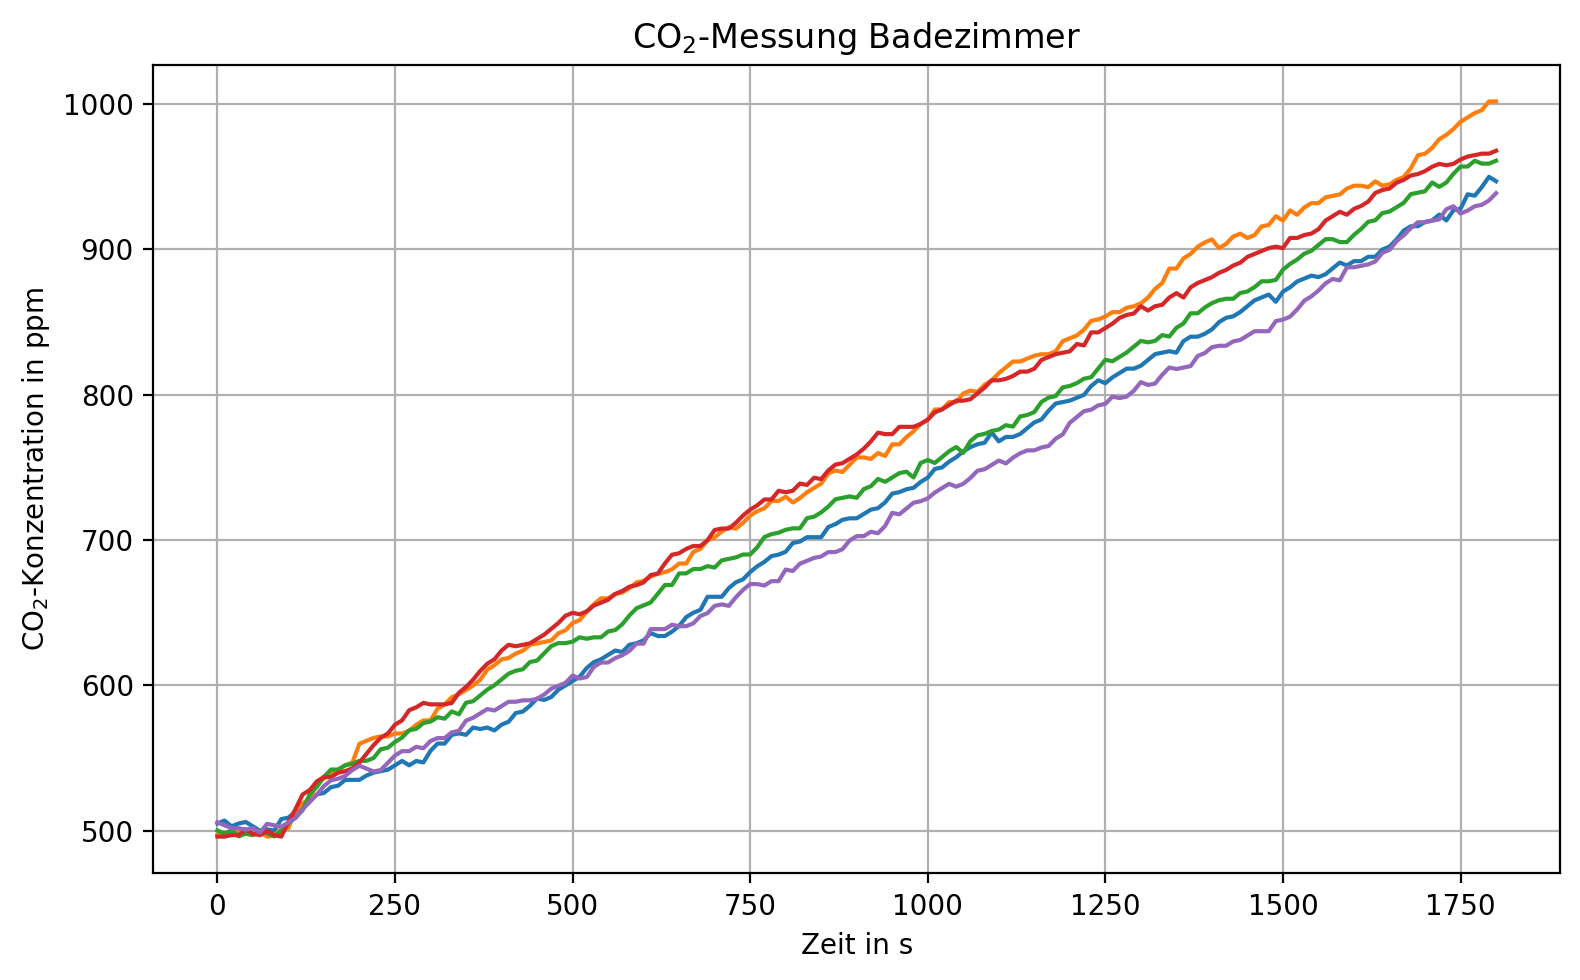

In [20]:
def find_offset(x):
    a, b, c, d = x
    res = 0
    for s1, s2, s3, s4, s5 in zip(bad1, bad2, bad3, bad4, bad5[:20]):
        d2 = (s1 - (s2+a))**2
        d3 = (s1 - (s3+b))**2
        d4 = (s1 - (s4+c))**2
        d5 = (s1 - (s5+d))**2
        res += d2  + d3 + d4 + d5
    return res

result = scipy.optimize.minimize(find_offset, [0, 0, 0, 60])
offsets = result.x
print(result)

fig = plt.figure(figsize=(8, 5), dpi=200)
ax = fig.add_subplot(111)

ax.set_title(r"CO$_2$-Messung Badezimmer")
ax.grid("both")

ax.set_xlabel(r"Zeit in s")
ax.set_ylabel(r"CO$_2$-Konzentration in ppm")

ax.plot(x_list, bad1, label="1")
ax.plot(x_list, bad2 + offsets[0], label="2")
ax.plot(x_list, bad3 + offsets[1], label="3")
ax.plot(x_list, bad4 + offsets[2], label="4")
ax.plot(x_list, bad5 + offsets[3], label="5")

fig.tight_layout()
plt.savefig("offset_Badezimmer.png")

plt.show()

In [21]:
o = bad1[0]
max_i = 60
versuch = np.concatenate((bad1[:max_i]-o, bad2[:max_i]+offsets[0]-o, bad3[:max_i]+offsets[1]-o, bad4[:max_i]+offsets[2]-o, bad5[:max_i]+offsets[3]-o))
x_list_full = np.concatenate((x_list[:max_i], x_list[:max_i], x_list[:max_i], x_list[:max_i], x_list[:max_i]))

c:\program files\python39\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[ 5.25240131e-02  2.86278477e+02  4.50787974e-06 -9.10041132e+00]


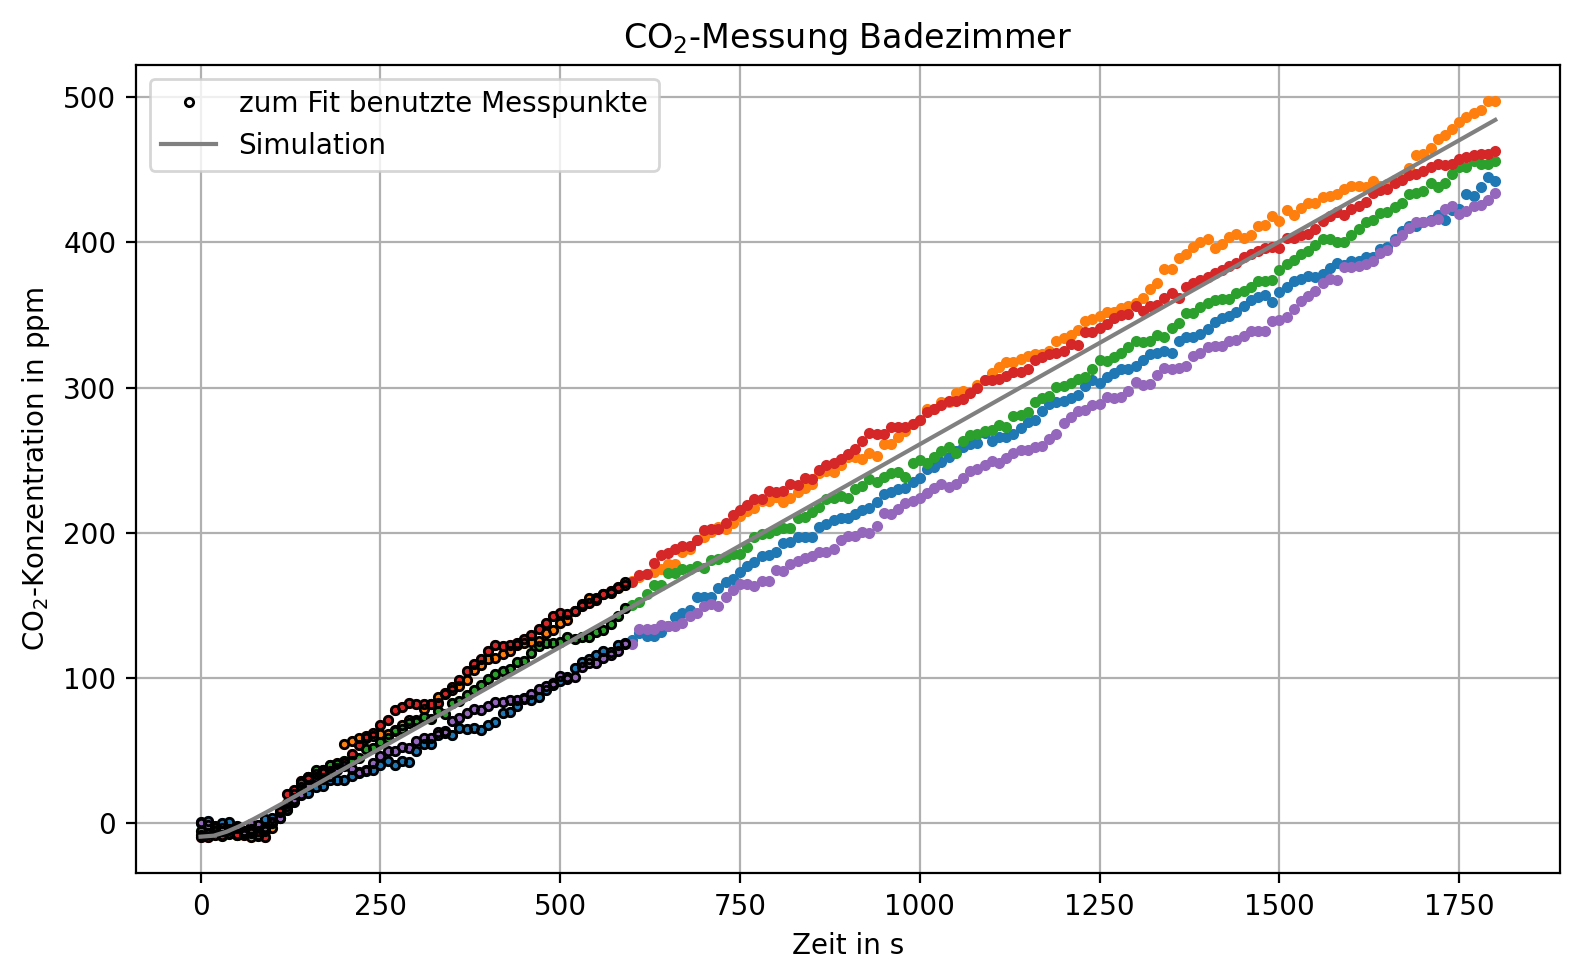

In [22]:
coeff, err = scipy.optimize.curve_fit(get_y_bad, x_list_full, versuch, p0=(0.04, 370, -0, -3))

print(coeff)
x_list_plot = np.linspace(0, 1800, 100)

fig = plt.figure(figsize=(8, 5), dpi=200)
ax = fig.add_subplot(111)

ax.set_title(r"CO$_2$-Messung Badezimmer")
ax.grid("both")

ax.set_xlabel(r"Zeit in s")
ax.set_ylabel(r"CO$_2$-Konzentration in ppm")

ax.plot(x_list, bad1-o, ".")
ax.plot(x_list, bad2+offsets[0]-o, ".")
ax.plot(x_list, bad3+offsets[1]-o, ".")
ax.plot(x_list, bad4+offsets[2]-o, ".")
ax.plot(x_list, bad5+offsets[3]-o, ".")
ax.plot(x_list_full, versuch, "k.", label="zum Fit benutzte Messpunkte", fillstyle="none")
ax.plot(x_list_plot, get_y_bad(x_list_plot, *coeff), "grey", label="Simulation")
ax.legend()

fig.tight_layout()
plt.savefig("fit_badezimmer.png", dpi=200)
plt.show()

## Versuch Wohnzimmer

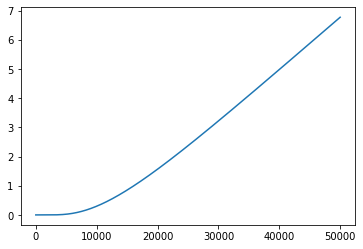

In [12]:
sensor_wohn = np.loadtxt("wohnzimmer_simulation.txt")
plt.plot(sensor_wohn)
plt.show()
# delta = sensor_schlaf[-1] - sensor_schlaf[-2]
# sensor_schlaf = np.concatenate((sensor_schlaf, np.arange(sensor_schlaf[-1] + delta, delta, 500)))

def get_y_wohn(times, d, s, ox=0, oy=0):
    dt = 1
    dd = 0.001
    try:
        res = np.zeros(len(times))
        for i, t in enumerate(times):
            index = ((t-ox)/dt * d/dd)
            if index <= 0:
                res[i] = 0
            elif index < len(sensor_wohn):
                res[i] = sensor_wohn[int(index)]
            else:
                res[i] = sensor_wohn[-1] + (index - len(sensor_wohn) + 1) * (sensor_wohn[-1] - sensor_wohn[-2])
            res[i] = res[i] * s * dd/d + oy
        return res
    except Exception as e:
        index = ((times-ox)/dt * d/dd)
        if index <= 0:
            return oy
        elif index < len(sensor_wohn):
            return sensor_wohn[int(index)] * s * dd/d + oy
        else:
            return sensor_wohn[-1] + (index - len(sensor_wohn) + 1) * (sensor_wohn[-1] - sensor_wohn[-2]) * s * dd/d + oy

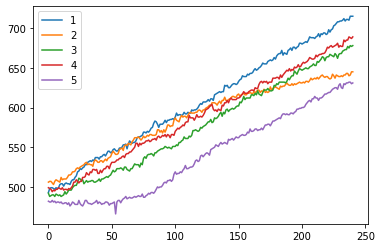

In [13]:
wohn1_file = np.genfromtxt(r"..\Data\Messungen\20210120_131444_log.csv", skip_header=46, skip_footer=2, delimiter=",")
wohn1 = wohn1_file[:, 3]
wohn2_file = np.genfromtxt(r"..\Data\Messungen\20210120_141226_log.csv", skip_header=46, skip_footer=2, delimiter=",")
wohn2 = wohn2_file[:, 3]
wohn3_file = np.genfromtxt(r"..\Data\Messungen\20210120_160004_log.csv", skip_header=46, skip_footer=2, delimiter=",")
wohn3 = wohn3_file[:, 3]
wohn4_file = np.genfromtxt(r"..\Data\Messungen\20210120_170349_log.csv", skip_header=46, skip_footer=2, delimiter=",")
wohn4 = wohn4_file[:, 3]
wohn5_file = np.genfromtxt(r"..\Data\Messungen\20210121_152657_log.csv", skip_header=46, skip_footer=2, delimiter=",")
wohn5 = wohn5_file[:, 3]

x_list = np.arange(0, len(wohn1)*10, 10)

plt.plot(wohn1, label="1")
plt.plot(wohn2, label="2")
plt.plot(wohn3, label="3")
plt.plot(wohn4, label="4")
plt.plot(wohn5, label="5")
plt.legend()
plt.show()

      fun: 1038.8500000001277
 hess_inv: array([[ 0.00346625, -0.00829183, -0.00228195, -0.00542279],
       [-0.00829183,  0.02059545,  0.00560027,  0.01265173],
       [-0.00228195,  0.00560027,  0.00156762,  0.00354936],
       [-0.00542279,  0.01265173,  0.00354936,  0.00880027]])
      jac: array([1.06811523e-04, 0.00000000e+00, 9.15527344e-05, 3.05175781e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 416
      nit: 23
     njev: 81
   status: 2
  success: False
        x: array([-8.24999849,  9.94999946,  4.05000182, 21.20000071])


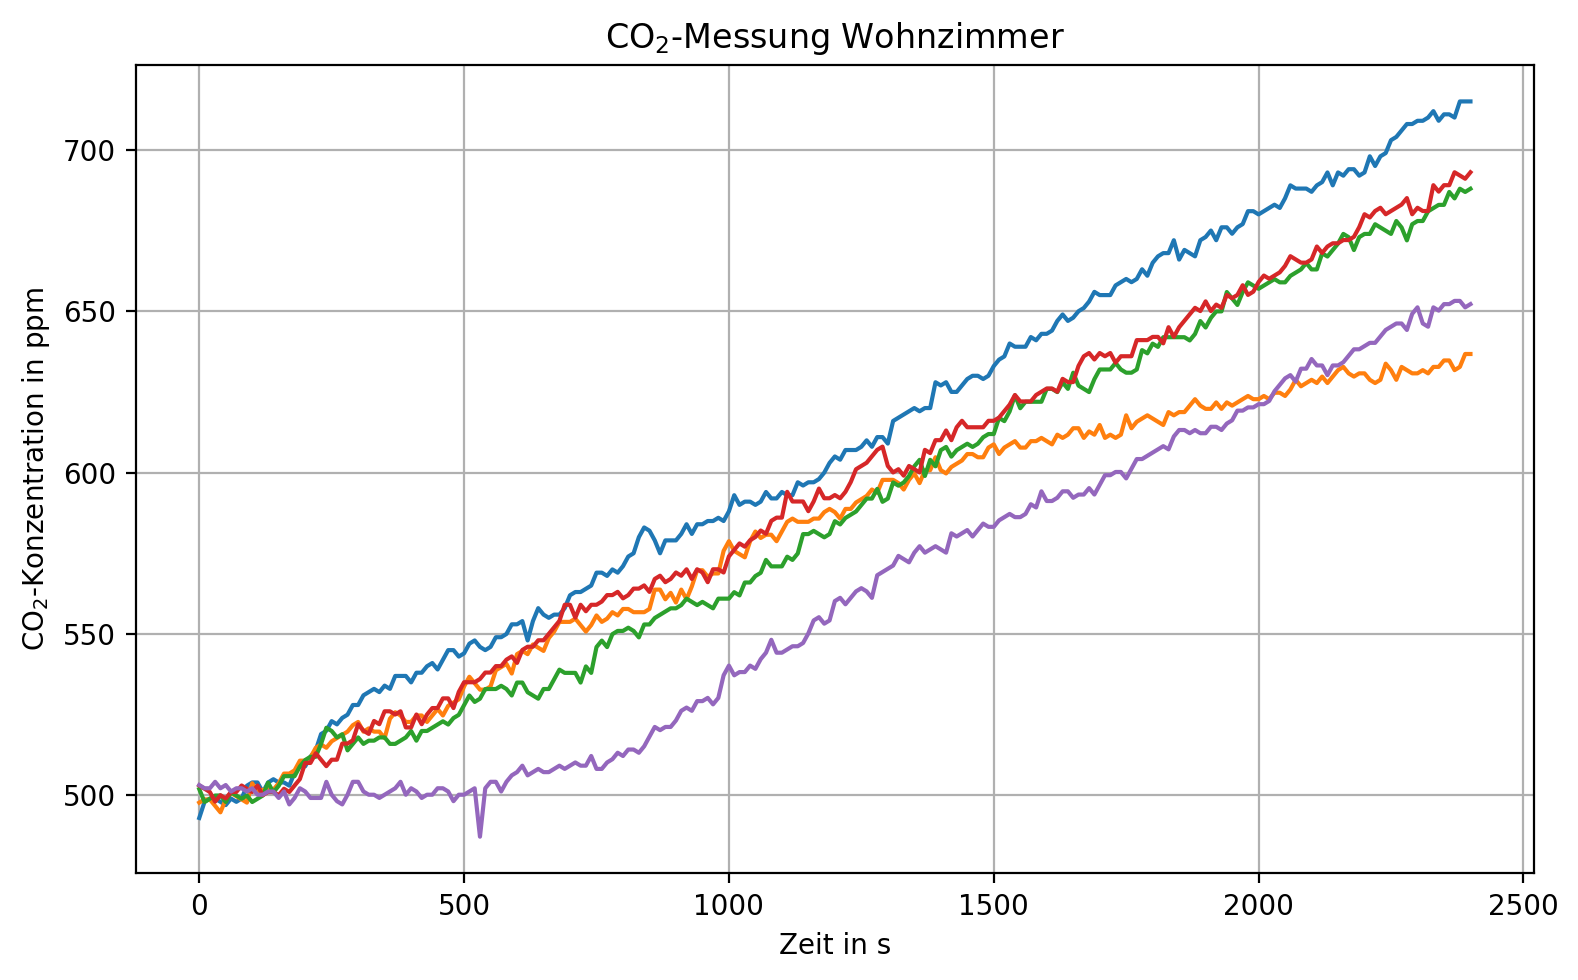

In [14]:
def find_offset(x):
    a, b, c, d = x
    res = 0
    for s1, s2, s3, s4, s5 in zip(wohn1, wohn2, wohn3, wohn4, wohn5[:20]):
        d2 = (s1 - (s2+a))**2
        d3 = (s1 - (s3+b))**2
        d4 = (s1 - (s4+c))**2
        d5 = (s1 - (s5+d))**2
        res += d2  + d3 + d4 + d5
    return res

result = scipy.optimize.minimize(find_offset, [0, 0, 0, 60])
offsets = result.x
print(result)

fig = plt.figure(figsize=(8, 5), dpi=200)
ax = fig.add_subplot(111)

ax.set_title(r"CO$_2$-Messung Wohnzimmer")
ax.grid("both")

ax.set_xlabel(r"Zeit in s")
ax.set_ylabel(r"CO$_2$-Konzentration in ppm")

ax.plot(x_list, wohn1, label="1")
ax.plot(x_list, wohn2 + offsets[0], label="2")
ax.plot(x_list, wohn3 + offsets[1], label="3")
ax.plot(x_list, wohn4 + offsets[2], label="4")
ax.plot(x_list, wohn5 + offsets[3], label="5")

fig.tight_layout()
plt.savefig("offset_wohnzimmer.png")
plt.show()

In [15]:
o = wohn1[0]
max_i = 60
versuch = np.concatenate((wohn1[:max_i]-o, wohn2[:max_i]+offsets[0]-o, wohn3[:max_i]+offsets[1]-o, wohn4[:max_i]+offsets[2]-o, wohn5[:max_i]+offsets[3]-o))
x_list_full = np.concatenate((x_list[:max_i], x_list[:max_i], x_list[:max_i], x_list[:max_i], x_list[:max_i]))

c:\program files\python39\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[ 2.89583270e-02  4.71993564e+02 -1.31903116e-04  9.42262982e+00]


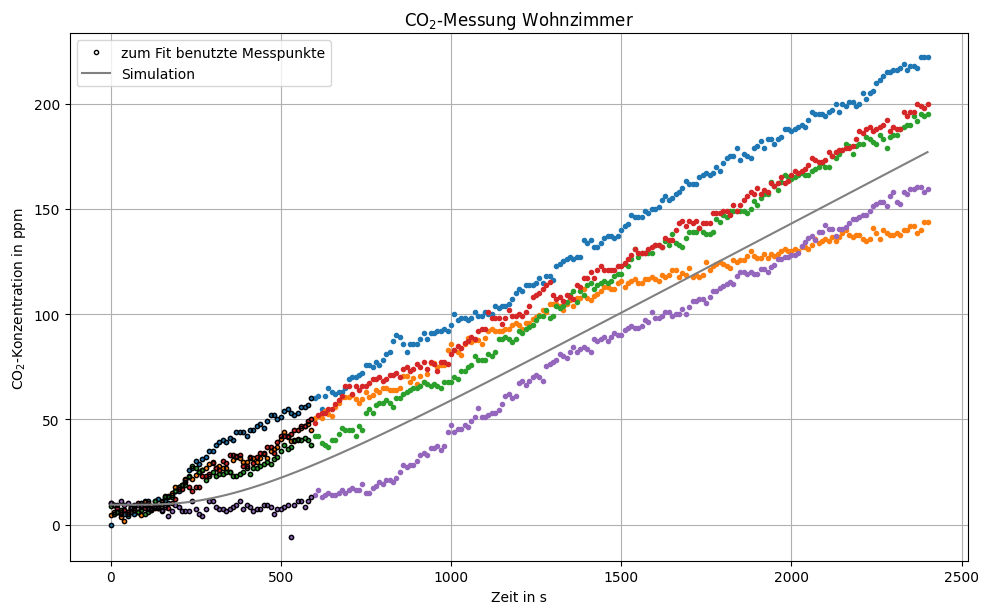

In [16]:
coeff, err = scipy.optimize.curve_fit(get_y_wohn, x_list_full, versuch, p0=(0.04, 370, -0, -3))

print(coeff)
x_list_plot = np.linspace(0, 2400, 100)

fig = plt.figure(figsize=(10, 5*1.25), dpi=100)
ax = fig.add_subplot(111)

ax.set_title(r"CO$_2$-Messung Wohnzimmer")
ax.grid("both")

ax.set_xlabel(r"Zeit in s")
ax.set_ylabel(r"CO$_2$-Konzentration in ppm")

ax.plot(x_list, wohn1-o, ".")
ax.plot(x_list, wohn2+offsets[0]-o, ".")
ax.plot(x_list, wohn3+offsets[1]-o, ".")
ax.plot(x_list, wohn4+offsets[2]-o, ".")
ax.plot(x_list, wohn5+offsets[3]-o, ".")
ax.plot(x_list_full, versuch, "k.", label="zum Fit benutzte Messpunkte", fillstyle="none")
ax.plot(x_list_plot, get_y_wohn(x_list_plot, *coeff), "grey", label="Simulation")

ax.legend()

fig.tight_layout()
plt.savefig("fit_wohnzimmer.png", dpi=200)
plt.show()